# A deep neural network approach to metal sub-genre classification from covers

A lot of examples of classification tasks realized by Neural Networks usually involve well defined exclusive classes. A contrario, musical sub-genre classification constitute, most of the time, a lattice of fuzzy, sometimes ill-defined, categories frontieres of which depends both on i) the music per se, ii) band location, iii) musical theme and iv) some "mental imagery" expressed through the artwork. 

This is especially true in Metal music, for "metalheads" seem to be able to infer the sub-genre from both the name of the band of the typical iconographic elements of covers. The high degre of human expertise together with the fuzzyness of the 13 main classes we choose to work with constitute an interesting chalenge. Let's start 

## Getting data
Despite of the absence of a well organized database, the are pretty interesting and structured ressources for the subject. We used this website https://www.metal-archives.com/


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import random
import scipy 
import time

from skimage import io,transform, color, exposure
from os import listdir
import pickle

from urllib.request import Request, urlopen,ProxyHandler

In [ ]:
randomPage = "https://www.metal-archives.com/band/random" # self explanatory

get Band info (style, name, artwork, etc etc)

In [ ]:
def GetCoverData(p):
    
    try:
        urlTest = Request(p, headers = {'User-Agent': 'Mozilla/5.0'})  
        pageStr = BeautifulSoup(urlopen(urlTest).read(),"lxml") # our parser
        
        # get band information
        bandName = [title.get_text() for title in pageStr.findAll('h1')][0]
        style = pageStr.find("div", {"id": "band_stats"}).find("dl" , {"class": "float_right"}).findAll("dd")[0].get_text()
        style = style.split("/")[0]
        
        # selecting on album (or EP if not)
        discoLink = pageStr.find("div", {"id":"band_disco"}).findAll("li")[0].find("a").get("href")
        disco = urlopen(discoLink).read()
        discoTab = pd.read_html(disco)[0]
        AlbumName = random.choice(discoTab[(discoTab["Type"] == "EP")|(discoTab["Type"] == "Full-length")]["Name"].values)
        AlbumLink = [a.get('href') for a in BeautifulSoup(disco,"lxml").findAll("a") if a.get_text() == AlbumName][0]
        
        #retreving the cover and convert it to a matrix
        target_size = 200
        coverLink = BeautifulSoup(urlopen(AlbumLink).read(),"lxml").find("div",{"class":"album_img"}).find("a",{"class":"image"}).get("href")
        
        img = io.imread(coverLink)
        print(type(img))
        
        H_ratio, W_ratio  = target_size/img.shape[0] , target_size/img.shape[1]
        
        img = transform.resize(img, (target_size,target_size), mode = 'edge')
        
        return(pd.Series([bandName,style,img,img.shape,AlbumLink]))
    except:
        print("Error, could not access")
        


In [ ]:
print(GetCoverData(randomPage))

In [ ]:
df = pd.DataFrame()
for i in range(1000): # I had to run it several times to get enough data
    print(i)
    df = df.append(GetCoverData(randomPage), ignore_index=True)
df.to_pickle("dataWeb/crop10")


## Refining data

First import saved data

In [ ]:
files = listdir("dataWeb")
data = pd.DataFrame()

print(files)

for f in files:
    d = pd.read_pickle("dataWeb/"+f)
    #data = data.append(d)
    data = pd.concat([data,d], ignore_index=True)
data.columns = ["band","style","img","shape","url"]


remove junk

In [ ]:
def RemoveJunk(d):
    BlackPic,WhitePic = np.zeros((200,200,3)), np.ones((200,200,3))
    d = d.drop_duplicates(subset="band") #remove duplicates
    d = d[(d["shape"]==(200, 200, 3))] #only consistent image matrix shapes (3D)
    #d = d[(d["img"]!=BlackPic)]
    return(d)
    


In [ ]:
data = RemoveJunk(data)

Let's check that we can read the images from the matrices

In [ ]:
plt.imshow(data["img"].loc[54], interpolation='nearest')
plt.show()

Seems OK. Now, the tricky part: a lot of style labels are redondant. Let's have a look. 

In [ ]:
data["style"].unique()

It might be good to clean this mess and create a dictionnary. Also, our futur algorithm needs numérical values to represent categories. Let's do it.

In [ ]:
StyleDictionnary ={"Doom": "Doom Metal",
                   "Drone":"Doom Metal",
                   "Sludge":"Doom Metal",
                   "Sludge Metal":"Doom Metal",
                   "Death":"Death Metal",
                   "Folk":"Folk Metal",
                   "Power":"Power Metal",
                   "Heavy":"Heavy Metal",
                   "Pagan":"Folk Metal",
                   "Viking":"Folk Metal",
                   "Progressive":"Progressive Metal",
                   "Deathcore":"Metalcore",
                   "Grindcore":"Metalcore",
                   "Thrash":"Thrash Metal",
                   "Brutal Death Metal":"Death Metal",
                   "Technical Death":"Death Metal",
                   "Gothic": "Gothic Metal",
                   "Black":"Black Metal"}

CommonAdjectives = ["Atmospheric","Melodic","Blackened","Experimental"]

In [ ]:
def AggregateStyle(s, dic):
    if s in dic: 
        return(dic[s])
    else: 
        return(s)

def AggregateStyle2(s,adj):
    sl = s.split(' ',1)
    if len(sl)>1: 
        if sl[0] in adj: 
            return(sl[1])
        if sl[0] == "Progressive":        # not sure about this one (we'll see)
            return("Progressive Metal")
    else:
        return(s)
    

In [ ]:
data["style"] = data["style"].apply(AggregateStyle2, args=(CommonAdjectives,))
data["style"] = data["style"].map(lambda a: AggregateStyle(a,StyleDictionnary))

In [ ]:
data["style"].value_counts()

Remove "minor" categories  

In [ ]:
BigOnes = data["style"].value_counts()[:13]
data = data[(data["style"].isin(BigOnes.index))]
data["style"].unique()

In [ ]:
data = data.reset_index(drop=True)
data.to_pickle("data")
data.head(5) 

and we are good to go

## Data augmentation

A common way to prevent the model to overfit the training data is to increase the number of m by i) flipping the images and/or by shifting their colours. Here is what I do

In [2]:
# IMPORT DATA 
data = pd.read_pickle("data")
data = data.reset_index(drop=True)
data.tail(2)
#data.head(3)

,band,style,img,shape,url
879,Inhumane Rites,Black Metal,"[[[0.171507352941, 0.132291666667, 0.124448529...","(200, 200, 3)",https://www.metal-archives.com/albums/Inhumane...
880,Anthropic,Metalcore,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","(200, 200, 3)",https://www.metal-archives.com/albums/Anthropi...


data augmentation: might prevent over fitting

In [3]:
data["imgR"] = data["img"].map(lambda a: np.flip(a,1)) # reverse image along L (axis 1)
data["imgRed"] = data["img"].map(lambda a :np.power(a,[1.5, 1.0, 1.0])) # reduce red

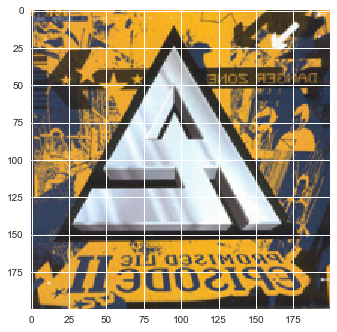

In [4]:
plt.imshow(data["imgR"][17], interpolation='nearest')
plt.show()

In [5]:
#good one 2 

data = data.reindex(np.random.permutation(data.index)) # shuffle data

#X = np.concatenate([np.expand_dims(data["img"][i], axis=0) for i in  range(len(data["img"]))],axis=0) #images
#Y = pd.get_dummies(data["style"], columns=["style"]).values # labels

X1 = np.concatenate([np.expand_dims(data["img"][i], axis=0) for i in  range(len(data["img"]))],axis=0) #images
X2 = np.concatenate([np.expand_dims(data["imgR"][i], axis=0) for i in  range(len(data["imgR"]))],axis=0) #images
X3 = np.concatenate([np.expand_dims(data["imgRed"][i], axis=0) for i in  range(len(data["imgRed"]))],axis=0) #images
X = np.concatenate([X1,X2,X3], axis =0)

Y = pd.get_dummies(data["style"], columns=["style"]).values # labels
Y = np.concatenate([Y,Y,Y], axis =0)

X_train,X_test  = X[200:],X[:200]
Y_train,Y_test  = Y[200:],Y[:200]

print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(2443, 200, 200, 3) (2443, 13) (200, 200, 200, 3) (200, 13)


Now, we need room (for it is one HUGE dataset)

In [6]:
del data 
import gc
gc.collect()

5035

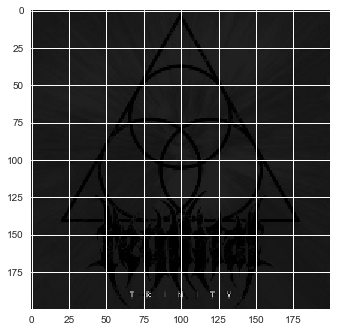

In [7]:
plt.imshow(X_test[1], interpolation='nearest')
plt.show()

## Built and train the Beast

We used a pretty simple Convolutionnal Neural Net build with Keras. Nothing fancy

Conv2D -> MaxPool -> Conv2D -> MaxPool -> Flattened -> FullyConnected -> SoftMax

In [8]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [9]:
def HappyModel(input_shape):

    ### START CODE HERE ###
    X_input = Input(input_shape)
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((7, 7))(X_input)
    
    # 2D CONV
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv0')(X)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X= Activation('relu')(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    
    # 2D CONV
    X = ZeroPadding2D((7, 7))(X)
    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X= Activation('relu')(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(13, activation='softmax', name='fc',bias_initializer='zeros')(X)
    # Create model. 
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    return model

In [10]:
happyModel = HappyModel((200,200,3))
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 214, 214, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 106, 106, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 106, 106, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 53, 53, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 67, 67, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 61, 64)        100416    
__________

In [11]:
happyModel.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])

In [12]:
happyModel.fit(x = X_train, y = Y_train, epochs = 10,verbose=1, batch_size = 64,validation_data=(X_test, Y_test))

Train on 2443 samples, validate on 200 samples
Epoch 1/10
2443/2443 [==============================] - 371s - loss: 2.3958 - categorical_accuracy: 0.1985 - val_loss: 2.2857 - val_categorical_accuracy: 0.1950
Epoch 2/10
2443/2443 [==============================] - 305s - loss: 2.2278 - categorical_accuracy: 0.2362 - val_loss: 2.1883 - val_categorical_accuracy: 0.1900
Epoch 3/10
2443/2443 [==============================] - 325s - loss: 1.9621 - categorical_accuracy: 0.3442 - val_loss: 1.8687 - val_categorical_accuracy: 0.3300
Epoch 4/10
2443/2443 [==============================] - 352s - loss: 1.4508 - categorical_accuracy: 0.5186 - val_loss: 1.3900 - val_categorical_accuracy: 0.5200
Epoch 5/10
2443/2443 [==============================] - 320s - loss: 0.9661 - categorical_accuracy: 0.6856 - val_loss: 0.8646 - val_categorical_accuracy: 0.6950
Epoch 6/10
2443/2443 [==============================] - 324s - loss: 0.5736 - categorical_accuracy: 0.8240 - val_loss: 0.4765 - val_categorical_accu

In [13]:
score = happyModel.evaluate(X_test, Y_test, verbose=0) 
score[1]

0.97999999999999998

Whaou! That's way better than what I expected from such a simple model (might even be better than most expert and nerdy metalheads)

In [14]:
happyModel.save("model1.h5")